# Data Reading

In [ ]:
!pip install hmmlearn

In [ ]:
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import pandas as pd
from hmmlearn.hmm import GaussianHMM
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_absolute_error
from sklearn.metrics import mean_squared_error
from sklearn.metrics import mean_absolute_percentage_error

In [ ]:
data =pd.read_csv('/content/drive/MyDrive/Jupyter Notebooks/data/MSFT.csv')
data.head()

,Date,Open,High,Low,Close,Adj Close,Volume
0,2021-01-04,222.529999,223.000000,214.809998,217.690002,211.605301,37130100
1,2021-01-05,217.259995,218.520004,215.699997,217.899994,211.809433,23823000
2,2021-01-06,212.169998,216.490005,211.940002,212.250000,206.317352,35930700
3,2021-01-07,214.039993,219.339996,213.710007,218.289993,212.188538,27694500
4,2021-01-08,218.679993,220.580002,217.029999,219.619995,213.481339,22956200


In [ ]:
data.describe()

,Open,High,Low,Close,Adj Close,Volume
count,753.000000,753.000000,753.000000,753.000000,753.000000,7.530000e+02
mean,286.107663,289.043466,283.130571,286.219137,282.062747,2.830042e+07
std,40.319480,40.330864,40.113798,40.287030,40.947497,1.039035e+07
min,212.169998,214.509995,211.940002,212.250000,206.317352,9.200800e+06
25%,251.000000,254.089996,248.729996,251.860001,247.389587,2.165650e+07
50%,283.959991,287.149994,280.170013,283.519989,278.528107,2.597860e+07
75%,320.029999,322.720001,316.209991,319.529999,316.617737,3.235650e+07
max,383.760010,384.299988,378.160004,382.700012,381.993622,9.042890e+07


In [ ]:
train_size = int(0.8*data.shape[0])
print(train_size)

602


In [ ]:
train_data = data.iloc[0:train_size]
test_data = data.iloc[train_size+1:]

In [ ]:
train_data.tail()

,Date,Open,High,Low,Close,Adj Close,Volume
597,2023-05-18,314.529999,319.040009,313.720001,318.519989,316.617737,27276000
598,2023-05-19,316.739990,318.750000,316.369995,318.339996,316.438782,27529500
599,2023-05-22,318.600006,322.589996,318.010010,321.179993,319.261841,24115700
600,2023-05-23,320.029999,322.720001,315.250000,315.260010,313.377197,30797200
601,2023-05-24,314.730011,316.500000,312.609985,313.850006,311.975616,23384900


In [ ]:
test_data.tail()

,Date,Open,High,Low,Close,Adj Close,Volume
748,2023-12-22,373.679993,375.179993,372.709991,374.579987,373.888580,17091100
749,2023-12-26,375.000000,376.940002,373.500000,374.660004,373.968445,12673100
750,2023-12-27,373.690002,375.059998,372.809998,374.070007,373.379547,14905400
751,2023-12-28,375.369995,376.459991,374.160004,375.279999,374.587280,14327000
752,2023-12-29,376.000000,377.160004,373.480011,376.040009,375.345886,18723000


In [ ]:
def augment_features(dataframe):
    fracocp = (dataframe['Close']-dataframe['Open'])/dataframe['Open']
    frachp = (dataframe['High']-dataframe['Open'])/dataframe['Open']
    fraclp = (dataframe['Open']-dataframe['Low'])/dataframe['Open']
    new_dataframe = pd.DataFrame({'delOpenClose': fracocp,
                                 'delHighOpen': frachp,
                                 'delLowOpen': fraclp})
    new_dataframe.set_index(dataframe.index)

    return new_dataframe

In [ ]:
def extract_features(dataframe):
    return np.column_stack((dataframe['delOpenClose'], dataframe['delHighOpen'], dataframe['delLowOpen']))

In [ ]:
features = extract_features(augment_features(train_data))

In [ ]:
features.shape

(602, 3)

In [ ]:
print(len(data))

753


# HMM

In [ ]:
model = GaussianHMM(n_components=3)
feature_train_data = augment_features(train_data)
features_train = extract_features(feature_train_data)
model.fit(features_train)

GaussianHMM(n_components=3)

In [ ]:
import itertools

test_augmented = augment_features(test_data)
fracocp = test_augmented['delOpenClose']
frachp = test_augmented['delHighOpen']
fraclp = test_augmented['delLowOpen']

sample_space_fracocp = np.linspace(fracocp.min(), fracocp.max(), 50)
sample_space_fraclp = np.linspace(fraclp.min(), frachp.max(), 10)
sample_space_frachp = np.linspace(frachp.min(), frachp.max(), 10)

possible_outcomes = np.array(list(itertools.product(sample_space_fracocp, sample_space_frachp, sample_space_fraclp)))

In [ ]:
num_latent_days = len(data)
num_days_to_predict = 30

In [ ]:
from tqdm import tqdm

predicted_close_prices = []
for i in tqdm(range(num_days_to_predict)):
    # Calculate start and end indices
    previous_data_start_index = max(0, i - num_latent_days)
    previous_data_end_index = max(0, i)
    # Acquire test data features for these days
    previous_data = extract_features(augment_features(test_data.iloc[previous_data_start_index:previous_data_end_index]))

    outcome_scores = []
    for outcome in possible_outcomes:
        # Append each outcome one by one with replacement to see which sequence generates the highest score
        total_data = np.row_stack((previous_data, outcome))
        outcome_scores.append(model.score(total_data))

    # Take the most probable outcome as the one with the highest score
    most_probable_outcome = possible_outcomes[np.argmax(outcome_scores)]
    predicted_close_prices.append(test_data.iloc[i]['Open'] * (1 + most_probable_outcome[0]))

100%|██████████| 30/30 [00:44<00:00,  1.50s/it]


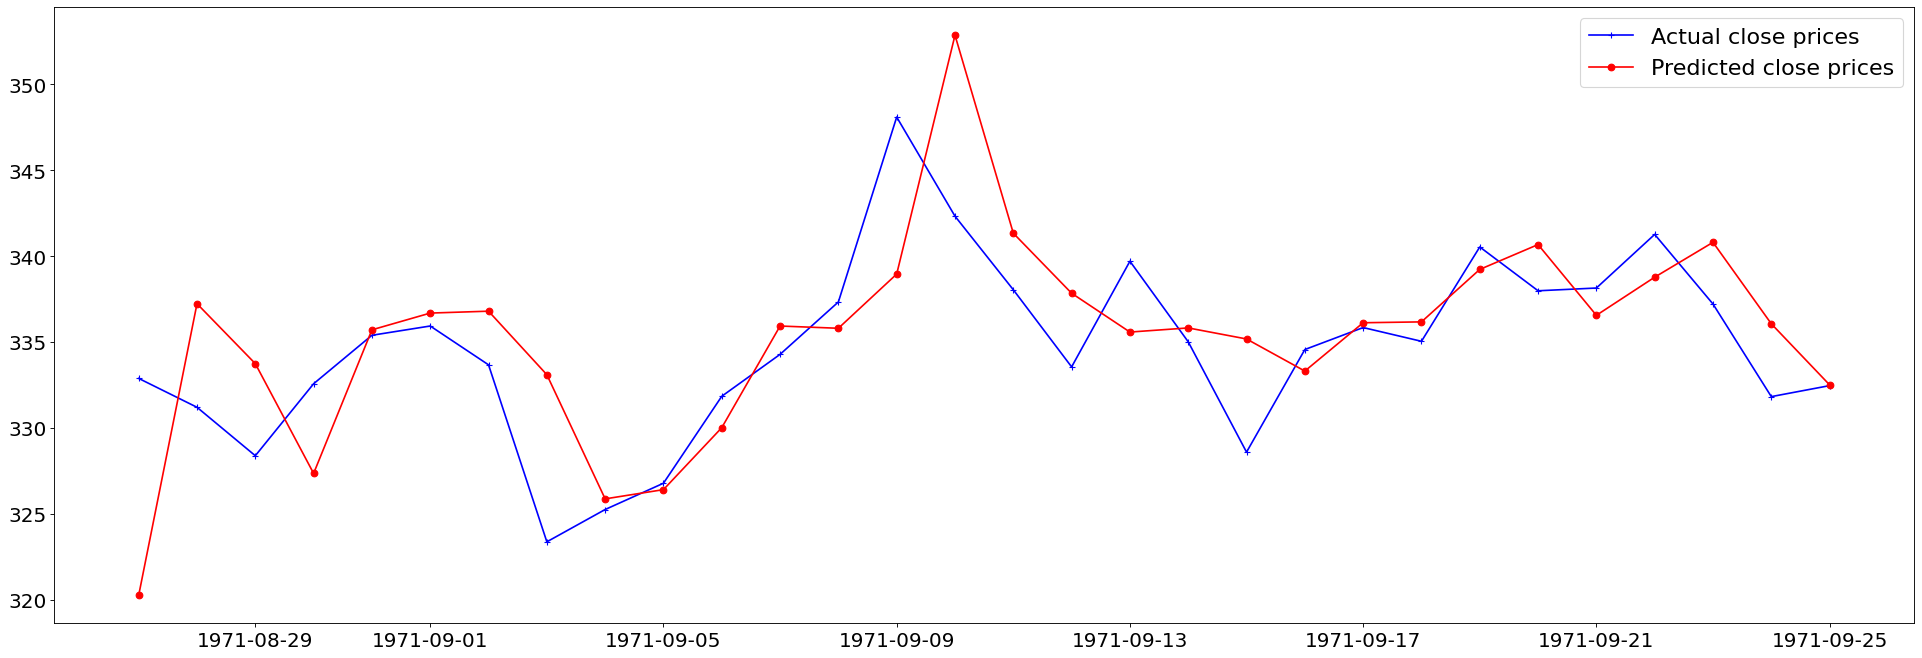

In [ ]:
import matplotlib.pyplot as plt

plt.figure(figsize=(30,10), dpi=80)
plt.rcParams.update({'font.size': 18})

x_axis = np.array(test_data.index[0:num_days_to_predict], dtype='datetime64[D]')
plt.plot(x_axis, test_data.iloc[0:num_days_to_predict]['Close'], 'b+-', label="Actual close prices")
plt.plot(x_axis, predicted_close_prices, 'ro-', label="Predicted close prices")
plt.legend(prop={'size': 20})
plt.show()

In [ ]:
print(x_axis)

['1970-01-01T00:00:00.603' '1970-01-01T00:00:00.604'
 '1970-01-01T00:00:00.605' '1970-01-01T00:00:00.606'
 '1970-01-01T00:00:00.607' '1970-01-01T00:00:00.608'
 '1970-01-01T00:00:00.609' '1970-01-01T00:00:00.610'
 '1970-01-01T00:00:00.611' '1970-01-01T00:00:00.612'
 '1970-01-01T00:00:00.613' '1970-01-01T00:00:00.614'
 '1970-01-01T00:00:00.615' '1970-01-01T00:00:00.616'
 '1970-01-01T00:00:00.617' '1970-01-01T00:00:00.618'
 '1970-01-01T00:00:00.619' '1970-01-01T00:00:00.620'
 '1970-01-01T00:00:00.621' '1970-01-01T00:00:00.622'
 '1970-01-01T00:00:00.623' '1970-01-01T00:00:00.624'
 '1970-01-01T00:00:00.625' '1970-01-01T00:00:00.626'
 '1970-01-01T00:00:00.627' '1970-01-01T00:00:00.628'
 '1970-01-01T00:00:00.629' '1970-01-01T00:00:00.630'
 '1970-01-01T00:00:00.631' '1970-01-01T00:00:00.632']


In [ ]:
y_test=test_data.iloc[0:num_days_to_predict]['Close']
y_pred=predicted_close_prices

mae = mean_absolute_error(y_test,y_pred)
mse = mean_squared_error(y_test,y_pred)
mape = mean_absolute_percentage_error(y_test,y_pred)

print("Mean Absolute Error:", mae)
print("Mean Squred Error:", mse)
print("Mean Absolute Percentage Error:",mape)

Mean Absolute Error: 3.5505346205340476
Mean Squred Error: 23.38518874460077
Mean Absolute Percentage Error: 0.01060807203276552
